In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import st_dep as st
import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'brk'
model_name = 'rnn'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
vocab_dep = generic.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']


word_to_index = generic.create_word_to_index(convai_train)

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

In [13]:
emb_dim = 100
vocab_size = len(word_to_index)
num_labels = 2
lstm_hidden_dim = 128

## ABOUT

In [14]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6758429063321821 	 Validation loss: 0.6591639872324668 	 
  1%|          | 574/57400 [00:11<14:49, 63.90it/s]
Epoch 2 	 Training loss: 0.6198905233929797 	 Validation loss: 0.6009966357279632 	 
  2%|▏         | 1148/57400 [00:21<14:38, 64.02it/s]
Epoch 3 	 Training loss: 0.5811437301934804 	 Validation loss: 0.5735694846864474 	 
  3%|▎         | 1722/57400 [00:30<14:31, 63.87it/s]
Epoch 4 	 Training loss: 0.5528121390720693 	 Validation loss: 0.552035951008231 	 
  4%|▍         | 2296/57400 [00:40<14:29, 63.39it/s]
Epoch 5 	 Training loss: 0.5291138218670357 	 Validation loss: 0.5329417753017555 	 
  5%|▌         | 2870/57400 [00:49<14:07, 64.35it/s]
Epoch 6 	 Training loss: 0.5085063097472805 	 Validation loss: 0.5200131409249064 	 
  6%|▌         | 3444/57400 [00:58<14:08, 63.56it/s]
Epoch 7 	 Training loss: 0.4924004882677922 	 Validation loss: 0.5070321458881184 	 
  7%|▋         | 4018/57400 [01:08<13:52, 64.15it/s]
Epoch 8 	 Training loss: 0.476665084

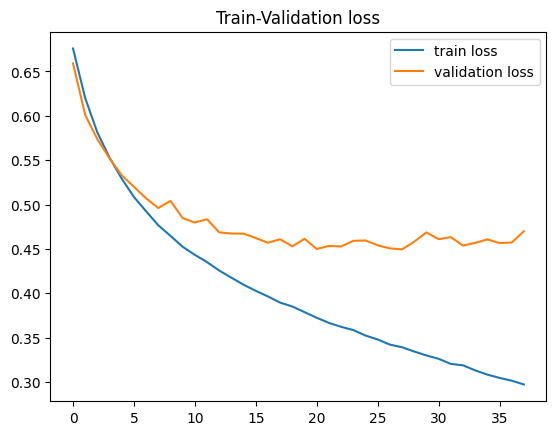

In [15]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.6475, 'male': 0.8151041666666666, 'average': 0.7313020833333332}
precision {'female': 0.7848484848484848, 'male': 0.6894273127753304, 'average': 0.7371378988119076}
f1 {'female': 0.7095890410958904, 'male': 0.7470167064439142, 'average': 0.7283028737699022}
accuracy 0.7295918367346939


Evaluación en el conjunto el conjunto to
recall {'female': 0.4776902887139108, 'male': 0.6885644768856448, 'average': 0.5831273827997778}
precision {'female': 0.5870967741935483, 'male': 0.5871369294605809, 'average': 0.5871168518270646}
f1 {'female': 0.5267727930535456, 'male': 0.6338185890257559, 'average': 0.5802956910396508}
accuracy 0.5871212121212122


Evaluación en el conjunto el conjunto as
recall {'female': 0.5336927223719676, 'male': 0.6388888888888888, 'average': 0.5862908056304282}
precision {'female': 0.5806451612903226, 'male': 0.5938967136150235, 'average': 0.587270937452673}
f1 {'female': 0.5561797752808988, 'male': 0.6155

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6769452411746314 	 Validation loss: 0.6651067743867131 	 
  1%|          | 574/57400 [00:09<15:01, 63.02it/s]
Epoch 2 	 Training loss: 0.6224650633667405 	 Validation loss: 0.5970439213817402 	 
  2%|▏         | 1148/57400 [00:19<14:44, 63.58it/s]
Epoch 3 	 Training loss: 0.5746305720419834 	 Validation loss: 0.5677868789535457 	 
  3%|▎         | 1722/57400 [00:28<14:32, 63.81it/s]
Epoch 4 	 Training loss: 0.5469676037075628 	 Validation loss: 0.5496643276537879 	 
  4%|▍         | 2296/57400 [00:38<14:25, 63.64it/s]
Epoch 5 	 Training loss: 0.5250613172295202 	 Validation loss: 0.5329298321473397 	 
  5%|▌         | 2870/57400 [00:47<14:24, 63.04it/s]
Epoch 6 	 Training loss: 0.5064370149830908 	 Validation loss: 0.5255679760949087 	 
  6%|▌         | 3444/57400 [00:57<15:04, 59.62it/s]
Epoch 7 	 Training loss: 0.4899933148655742 	 Validation loss: 0.5139117432852923 	 
  7%|▋         | 4018/57400 [01:07<14:32, 61.15it/s]
Epoch 8 	 Training loss: 0.47504847

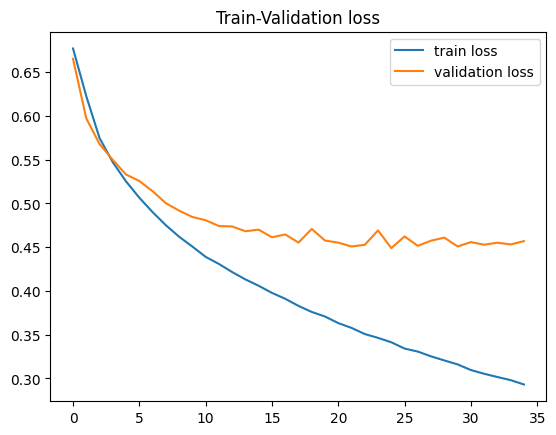

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.6925, 'male': 0.7864583333333334, 'average': 0.7394791666666667}
precision {'female': 0.7715877437325905, 'male': 0.7105882352941176, 'average': 0.7410879895133541}
f1 {'female': 0.7299077733860343, 'male': 0.7466007416563658, 'average': 0.7382542575212001}
accuracy 0.7385204081632653


Evaluación en el conjunto el conjunto to
recall {'female': 0.5328083989501312, 'male': 0.681265206812652, 'average': 0.6070368028813916}
precision {'female': 0.6077844311377245, 'male': 0.611353711790393, 'average': 0.6095690714640587}
f1 {'female': 0.5678321678321678, 'male': 0.6444188722669735, 'average': 0.6061255200495707}
accuracy 0.6098484848484849


Evaluación en el conjunto el conjunto as
recall {'female': 0.5795148247978437, 'male': 0.648989898989899, 'average': 0.6142523618938713}
precision {'female': 0.6073446327683616, 'male': 0.6222760290556901, 'average': 0.6148103309120259}
f1 {'female': 0.593103448275862, 'male': 0.6353522

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6759750534640787 	 Validation loss: 0.6652834344718416 	 
  1%|          | 574/57400 [00:09<15:07, 62.65it/s]
Epoch 2 	 Training loss: 0.6271476197325809 	 Validation loss: 0.6042735182632835 	 
  2%|▏         | 1148/57400 [00:19<15:02, 62.31it/s]
Epoch 3 	 Training loss: 0.5844837291107776 	 Validation loss: 0.5806133413718919 	 
  3%|▎         | 1722/57400 [00:28<14:48, 62.69it/s]
Epoch 4 	 Training loss: 0.5545359573193959 	 Validation loss: 0.5586093507580838 	 
  4%|▍         | 2296/57400 [00:38<14:29, 63.37it/s]
Epoch 5 	 Training loss: 0.5298142744689037 	 Validation loss: 0.5418241140195879 	 
  5%|▌         | 2870/57400 [00:47<14:56, 60.81it/s]
Epoch 6 	 Training loss: 0.5087475686850033 	 Validation loss: 0.524427107330096 	 
  6%|▌         | 3444/57400 [00:57<14:14, 63.15it/s]
Epoch 7 	 Training loss: 0.48976687001849717 	 Validation loss: 0.5124819096872362 	 
  7%|▋         | 4018/57400 [01:07<14:27, 61.52it/s]
Epoch 8 	 Training loss: 0.47411770

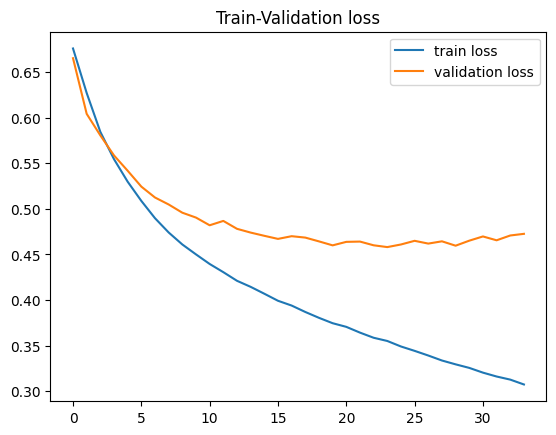

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_about3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.665, 'male': 0.7890625, 'average': 0.72703125}
precision {'female': 0.7665706051873199, 'male': 0.6933638443935927, 'average': 0.7299672247904563}
f1 {'female': 0.7121820615796519, 'male': 0.7381242387332523, 'average': 0.7251531501564521}
accuracy 0.7257653061224489


Evaluación en el conjunto el conjunto to
recall {'female': 0.5275590551181102, 'male': 0.6374695863746959, 'average': 0.582514320746403}
precision {'female': 0.5742857142857143, 'male': 0.5927601809954751, 'average': 0.5835229476405948}
f1 {'female': 0.5499316005471956, 'male': 0.6143024618991794, 'average': 0.5821170312231875}
accuracy 0.5845959595959596


Evaluación en el conjunto el conjunto as
recall {'female': 0.6199460916442049, 'male': 0.6212121212121212, 'average': 0.620579106428163}
precision {'female': 0.6052631578947368, 'male': 0.6356589147286822, 'average': 0.6204610363117096}
f1 {'female': 0.6125166444740346, 'male': 0.6283524904214559, 'aver

In [21]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.7305700938158515
f1 etiqueta male: 0.7439138956111774
f1 etiqueta female:  0.7172262920205256


TO
Resultado global f1: 0.5895127474374696
f1 etiqueta male: 0.6308466410639696
f1 etiqueta female:  0.5481788538109696


AS
Resultado global f1: 0.606846070230294
f1 etiqueta male: 0.6264255177836562
f1 etiqueta female:  0.5872666226769319


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.7326041666666666
recall etiqueta male: 0.796875
recall etiqueta female:  0.6683333333333333


TO
Resultado global recall: 0.5908928354758575
recall etiqueta male: 0.6690997566909975
recall etiqueta female:  0.5126859142607174


AS
Resultado global recall: 0.6070407579841542
recall etiqueta male: 0.6363636363636364
recall etiqueta female:  0.577717879604672


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.7360643710385727
precision etiqueta male: 0.6977931308210136
precision etiqueta female:  0.7743356112561

## TO

In [22]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936775202950534 	 Validation loss: 0.6926124782885535 	 
  1%|          | 574/57400 [00:10<15:44, 60.15it/s]
Epoch 2 	 Training loss: 0.6933262817535666 	 Validation loss: 0.6934008376073029 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:20<15:26, 60.70it/s]
Epoch 3 	 Training loss: 0.6932762084522314 	 Validation loss: 0.6923042010452788 	 
  3%|▎         | 1722/57400 [00:30<15:32, 59.72it/s]
Epoch 4 	 Training loss: 0.6932265937120657 	 Validation loss: 0.6922704365293858 	 
  4%|▍         | 2296/57400 [00:40<16:04, 57.12it/s]
Epoch 5 	 Training loss: 0.6930556164385965 	 Validation loss: 0.6922373246338408 	 
  5%|▌         | 2870/57400 [00:50<15:05, 60.22it/s]
Epoch 6 	 Training loss: 0.6930162235834872 	 Validation loss: 0.6932523311194727 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [01:00<14:46, 60.87it/s]
Epoch 7 	 Training loss: 0.6928740573677037 	 Validation loss: 0.6941927125898458 	 

2 epoch without improvement
 

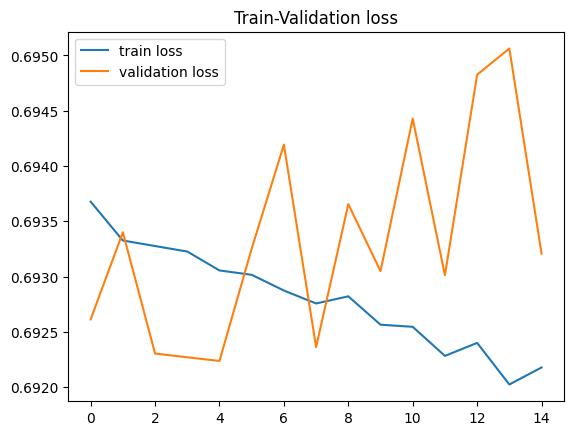

In [23]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.73, 'male': 0.2604166666666667, 'average': 0.49520833333333336}
precision {'female': 0.5069444444444444, 'male': 0.4807692307692308, 'average': 0.49385683760683763}
f1 {'female': 0.5983606557377048, 'male': 0.33783783783783783, 'average': 0.4680992467877713}
accuracy 0.5


Evaluación en el conjunto el conjunto to
recall {'female': 0.7532808398950132, 'male': 0.2871046228710462, 'average': 0.5201927313830297}
precision {'female': 0.49482758620689654, 'male': 0.5566037735849056, 'average': 0.5257156798959011}
f1 {'female': 0.5972944849115505, 'male': 0.37881219903691815, 'average': 0.48805334197423433}
accuracy 0.5113636363636364


Evaluación en el conjunto el conjunto as
recall {'female': 0.7547169811320755, 'male': 0.2297979797979798, 'average': 0.49225748046502765}
precision {'female': 0.47863247863247865, 'male': 0.5, 'average': 0.48931623931623935}
f1 {'female': 0.5857740585774058, 'male': 0.314878892733564, 'average'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936589762931917 	 Validation loss: 0.6940881599814205 	 
  1%|          | 574/57400 [00:10<16:13, 58.36it/s]
Epoch 2 	 Training loss: 0.693513375126111 	 Validation loss: 0.69135069240958 	 
  2%|▏         | 1148/57400 [00:20<15:57, 58.72it/s]
Epoch 3 	 Training loss: 0.6933406343235787 	 Validation loss: 0.6969409393051923 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:30<15:27, 60.00it/s]
Epoch 4 	 Training loss: 0.6931865204917429 	 Validation loss: 0.6928513625920829 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:40<15:24, 59.58it/s]
Epoch 5 	 Training loss: 0.6930169373854528 	 Validation loss: 0.693792159274473 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:50<15:11, 59.84it/s]
Epoch 6 	 Training loss: 0.6929900994076547 	 Validation loss: 0.6952575495687582 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [01:00<14:59, 59.98it/s]
Epoch 7 	 Training loss: 0.6927329683968414 	 Validation loss

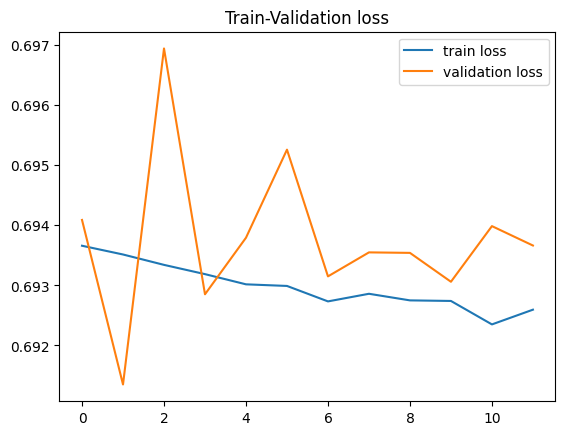

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.99, 'male': 0.005208333333333333, 'average': 0.4976041666666667}
precision {'female': 0.5089974293059126, 'male': 0.3333333333333333, 'average': 0.421165381319623}
f1 {'female': 0.6723259762308998, 'male': 0.010256410256410256, 'average': 0.34129119324365503}
accuracy 0.5076530612244898


Evaluación en el conjunto el conjunto to
recall {'female': 1.0, 'male': 0.0024330900243309003, 'average': 0.5012165450121655}
precision {'female': 0.48166877370417194, 'male': 1.0, 'average': 0.7408343868520859}
f1 {'female': 0.6501706484641638, 'male': 0.0048543689320388345, 'average': 0.32751250869810133}
accuracy 0.4823232323232323


Evaluación en el conjunto el conjunto as
recall {'female': 0.9973045822102425, 'male': 0.0, 'average': 0.49865229110512127}
precision {'female': 0.4830287206266319, 'male': 0.0, 'average': 0.24151436031331594}
f1 {'female': 0.6508355321020228, 'male': 0.0, 'average': 0.3254177660510114}
accuracy 0.482398

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937673055544132 	 Validation loss: 0.6951531878972458 	 
  1%|          | 574/57400 [00:10<16:07, 58.76it/s]
Epoch 2 	 Training loss: 0.6934301462738356 	 Validation loss: 0.6923866585149603 	 
  2%|▏         | 1148/57400 [00:20<15:35, 60.11it/s]
Epoch 3 	 Training loss: 0.6930626284993069 	 Validation loss: 0.6928874506788739 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:30<15:30, 59.85it/s]
Epoch 4 	 Training loss: 0.6929896467654132 	 Validation loss: 0.6955290911561351 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:40<15:03, 61.00it/s]
Epoch 5 	 Training loss: 0.6929805227896062 	 Validation loss: 0.6926069431385752 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:50<15:06, 60.15it/s]
Epoch 6 	 Training loss: 0.6929356879473564 	 Validation loss: 0.6923406598931652 	 
  6%|▌         | 3444/57400 [01:00<15:03, 59.74it/s]
Epoch 7 	 Training loss: 0.693005560686364 	 Validation loss: 0.6932662331451804 	 

1

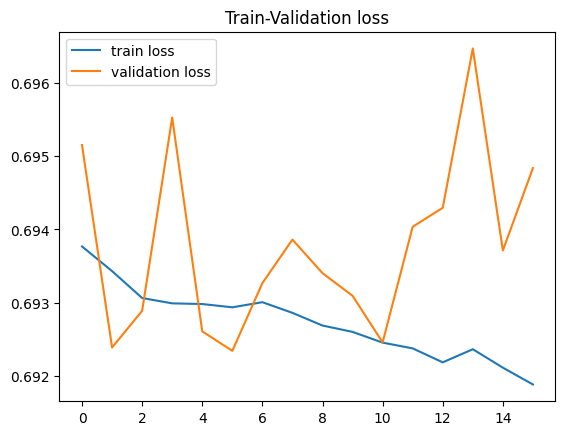

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_to3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.8525, 'male': 0.16145833333333334, 'average': 0.5069791666666666}
precision {'female': 0.5143288084464555, 'male': 0.512396694214876, 'average': 0.5133627513306658}
f1 {'female': 0.6415804327375352, 'male': 0.24554455445544554, 'average': 0.44356249359649036}
accuracy 0.514030612244898


Evaluación en el conjunto el conjunto to
recall {'female': 0.8241469816272966, 'male': 0.170316301703163, 'average': 0.4972316416652298}
precision {'female': 0.47938931297709925, 'male': 0.5109489051094891, 'average': 0.49516910904329414}
f1 {'female': 0.6061776061776062, 'male': 0.2554744525547445, 'average': 0.4308260293661753}
accuracy 0.48484848484848486


Evaluación en el conjunto el conjunto as
recall {'female': 0.8463611859838275, 'male': 0.15151515151515152, 'average': 0.4989381687494895}
precision {'female': 0.48307692307692307, 'male': 0.5128205128205128, 'average': 0.4979487179487179}
f1 {'female': 0.6150832517140059, 'male': 

In [29]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4176509778759722
f1 etiqueta male: 0.19787960084989786
f1 etiqueta female:  0.6374223549020466


TO
Resultado global f1: 0.415463960012837
f1 etiqueta male: 0.21304700684123382
f1 etiqueta female:  0.6178809131844402


AS
Resultado global f1: 0.4000816439636615
f1 etiqueta male: 0.18293234046284493
f1 etiqueta female:  0.6172309474644782


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.49993055555555554
recall etiqueta male: 0.14236111111111113
recall etiqueta female:  0.8575


TO
Resultado global recall: 0.506213639353475
recall etiqueta male: 0.1532846715328467
recall etiqueta female:  0.8591426071741033


AS
Resultado global recall: 0.4966159801065461
recall etiqueta male: 0.1271043771043771
recall etiqueta female:  0.8661275831087152


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.47612832341904215
precision etiqueta male: 0.4421664194391467
precision etiqueta female:  0.510090227

## AS

In [30]:
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937450654415304 	 Validation loss: 0.6944324202456716 	 
  1%|          | 574/57400 [00:10<15:24, 61.44it/s]
Epoch 2 	 Training loss: 0.6933889552068212 	 Validation loss: 0.6934868248842531 	 
  2%|▏         | 1148/57400 [00:20<15:32, 60.35it/s]
Epoch 3 	 Training loss: 0.6931045890269795 	 Validation loss: 0.6926457538443097 	 
  3%|▎         | 1722/57400 [00:30<15:59, 58.03it/s]
Epoch 4 	 Training loss: 0.6929583524577709 	 Validation loss: 0.6947022888620021 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:40<15:01, 61.10it/s]
Epoch 5 	 Training loss: 0.6928232676683818 	 Validation loss: 0.6931599277560994 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:50<15:10, 59.88it/s]
Epoch 6 	 Training loss: 0.6927606796761423 	 Validation loss: 0.6919927930427809 	 
  6%|▌         | 3444/57400 [01:00<14:59, 59.96it/s]
Epoch 7 	 Training loss: 0.6924401726249203 	 Validation loss: 0.6931195521758775 	 

1 epoch without improvement
 

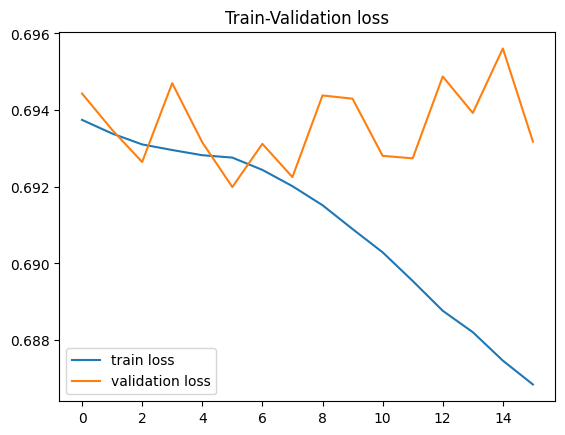

In [31]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.44, 'male': 0.4140625, 'average': 0.42703125}
precision {'female': 0.4389027431421446, 'male': 0.4151436031331593, 'average': 0.4270231731376519}
f1 {'female': 0.4394506866416979, 'male': 0.41460234680573665, 'average': 0.4270265167237173}
accuracy 0.4272959183673469


Evaluación en el conjunto el conjunto to
recall {'female': 0.5826771653543307, 'male': 0.48905109489051096, 'average': 0.5358641301224208}
precision {'female': 0.5138888888888888, 'male': 0.5583333333333333, 'average': 0.5361111111111111}
f1 {'female': 0.5461254612546126, 'male': 0.5214007782101168, 'average': 0.5337631197323647}
accuracy 0.5340909090909091


Evaluación en el conjunto el conjunto as
recall {'female': 0.6253369272237197, 'male': 0.44191919191919193, 'average': 0.5336280595714558}
precision {'female': 0.5121412803532008, 'male': 0.5573248407643312, 'average': 0.534733060558766}
f1 {'female': 0.5631067961165048, 'male': 0.49295774647887325, '

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693637937203517 	 Validation loss: 0.6938520690142098 	 
  1%|          | 574/57400 [00:10<16:02, 59.04it/s]
Epoch 2 	 Training loss: 0.6932757508256294 	 Validation loss: 0.6928204873860893 	 
  2%|▏         | 1148/57400 [00:20<15:18, 61.21it/s]
Epoch 3 	 Training loss: 0.693129902932702 	 Validation loss: 0.6937639066728495 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:30<15:27, 60.04it/s]
Epoch 4 	 Training loss: 0.6928388752588411 	 Validation loss: 0.6935974743406651 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:40<15:12, 60.38it/s]
Epoch 5 	 Training loss: 0.6929262150663117 	 Validation loss: 0.6927411232964468 	 
  5%|▌         | 2870/57400 [00:50<15:18, 59.34it/s]
Epoch 6 	 Training loss: 0.6925320479927993 	 Validation loss: 0.692790626469305 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [01:00<14:58, 60.04it/s]
Epoch 7 	 Training loss: 0.6922400652946911 	 Validation loss: 0.6915698384834548 	 
  7%

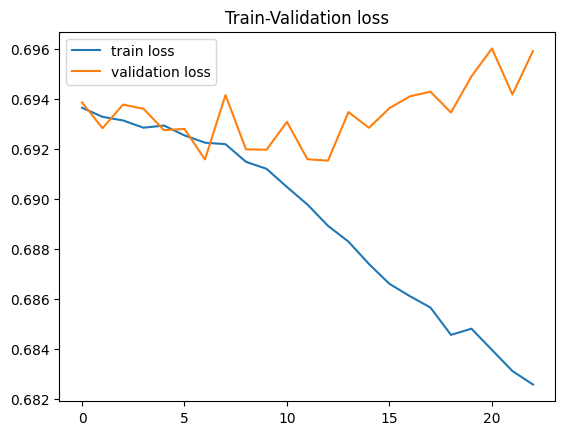

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.3975, 'male': 0.5052083333333334, 'average': 0.4513541666666667}
precision {'female': 0.45558739255014324, 'male': 0.4459770114942529, 'average': 0.4507822020221981}
f1 {'female': 0.42456608811749, 'male': 0.47374847374847384, 'average': 0.4491572809329819}
accuracy 0.4502551020408163


Evaluación en el conjunto el conjunto to
recall {'female': 0.4199475065616798, 'male': 0.6058394160583942, 'average': 0.512893461310037}
precision {'female': 0.4968944099378882, 'male': 0.5297872340425532, 'average': 0.5133408219902207}
f1 {'female': 0.4551920341394025, 'male': 0.565266742338252, 'average': 0.5102293882388272}
accuracy 0.5164141414141414


Evaluación en el conjunto el conjunto as
recall {'female': 0.4555256064690027, 'male': 0.6287878787878788, 'average': 0.5421567426284407}
precision {'female': 0.5348101265822784, 'male': 0.5521064301552107, 'average': 0.5434582783687445}
f1 {'female': 0.4919941775836972, 'male': 0.58795

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6935876837383164 	 Validation loss: 0.6936720538947542 	 
  1%|          | 574/57400 [00:10<15:47, 59.99it/s]
Epoch 2 	 Training loss: 0.6933194197428767 	 Validation loss: 0.6919325105214523 	 
  2%|▏         | 1148/57400 [00:20<15:48, 59.30it/s]
Epoch 3 	 Training loss: 0.6930089294910431 	 Validation loss: 0.6932926097158658 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:30<15:22, 60.34it/s]
Epoch 4 	 Training loss: 0.6929756152712925 	 Validation loss: 0.6956999291807918 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:40<15:43, 58.38it/s]
Epoch 5 	 Training loss: 0.6924506517237488 	 Validation loss: 0.6918749001066563 	 
  5%|▌         | 2870/57400 [00:50<14:58, 60.71it/s]
Epoch 6 	 Training loss: 0.6925095981214104 	 Validation loss: 0.6940121448646157 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [01:00<15:20, 58.64it/s]
Epoch 7 	 Training loss: 0.6922513821814533 	 Validation loss: 0.6919745812981816 	 



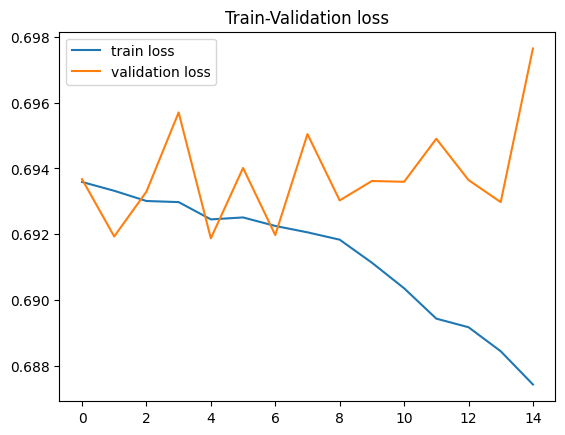

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'{model_name}_{encoding_type}_as3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,num_labels=num_labels,lstm_hidden_dim = lstm_hidden_dim).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])



Evaluación en el conjunto el conjunto about
recall {'female': 0.7, 'male': 0.20572916666666666, 'average': 0.4528645833333333}
precision {'female': 0.47863247863247865, 'male': 0.3969849246231156, 'average': 0.4378087016277971}
f1 {'female': 0.5685279187817258, 'male': 0.27101200686106347, 'average': 0.41976996282139467}
accuracy 0.45790816326530615


Evaluación en el conjunto el conjunto to
recall {'female': 0.7296587926509186, 'male': 0.26034063260340634, 'average': 0.49499971262716247}
precision {'female': 0.47766323024054985, 'male': 0.5095238095238095, 'average': 0.4935935198821797}
f1 {'female': 0.5773624091381101, 'male': 0.3446054750402576, 'average': 0.46098394208918386}
accuracy 0.4861111111111111


Evaluación en el conjunto el conjunto as
recall {'female': 0.7654986522911051, 'male': 0.22727272727272727, 'average': 0.4963856897819162}
precision {'female': 0.48135593220338985, 'male': 0.5084745762711864, 'average': 0.4949152542372881}
f1 {'female': 0.5910509885535901, 'male

In [37]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4319845868260313
f1 etiqueta male: 0.38645427580509134
f1 etiqueta female:  0.47751489784697126


TO
Resultado global f1: 0.5016588166867919
f1 etiqueta male: 0.4770909985295421
f1 etiqueta female:  0.5262266348440418


AS
Resultado global f1: 0.5068672219059203
f1 etiqueta male: 0.4650171230605765
f1 etiqueta female:  0.548717320751264


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.44375
recall etiqueta male: 0.375
recall etiqueta female:  0.5125


TO
Resultado global recall: 0.5145857680198734
recall etiqueta male: 0.45174371451743717
recall etiqueta female:  0.5774278215223096


AS
Resultado global recall: 0.5240568306606043
recall etiqueta male: 0.43265993265993263
recall etiqueta female:  0.6154537286612758


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.4385380255958824
precision etiqueta male: 0.41936851308350925
precision etiqueta female:  0.4577075381082555


TO
Resultado g